In [109]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys

from tqdm import tqdm
from tokenize import tokenize
from clean_tokenizer import tokenize_tweets

# Import module from gsdmm repository
sys.path.insert(0, '../gsdmm/')
from gsdmm import MovieGroupProcess

In [110]:
# Import preprocessed clean tweet data 
data_dir = '../input/english_health_tweets.csv'
tweets_df = pd.read_csv(data_dir) 
tweets_df.head()

,id,date,timezone,tweet,hashtags,username,name,day,hour,retweet,nlikes,nreplies,nretweets,clean_tweet
0,1244004590699384833,2020-03-28 20:53:01,UTC,"Schlifke said, he and members of the CovidVent...",['#covid19'],KHNews,Kaiser Health News,4,3,False,0,0,1,schlifke say members covidvent coalition help ...
1,1243979929437507585,2020-03-28 19:15:01,UTC,Millions of Americans are seeking care by conn...,"['#covid19', '#telemedicine']",KHNews,Kaiser Health News,6,2,False,6,0,2,millions americans seek care connect doctor el...
2,1243956772123090944,2020-03-28 17:43:00,UTC,We're following the #coronaviruspandemic close...,"['#coronaviruspandemic', '#healthcare', '#heal...",KHNews,Kaiser Health News,5,4,False,0,0,1,follow closely bring best investigation surrou...
3,1243941673270460418,2020-03-28 16:43:00,UTC,About $100 billion of the funding is intended ...,"['#coronavirus', '#relieffunds', '#healthbent']",KHNews,Kaiser Health News,5,12,False,1,0,1,billion fund intend put reimburse eligible hea...
4,1243911473480556544,2020-03-28 14:43:00,UTC,Read KHN's top #COVID19 coverage: The U.S. mil...,['#covid19'],KHNews,Kaiser Health News,6,4,False,4,1,7,read coverage military fly specialize swab ita...


### Short Term Text Modeling (STTM)

In [111]:
# Convert cleaned tweet into tokens list
tweets_df['clean_tokens'] = tweets_df.clean_tweet.apply(lambda x: re.split('\s', x))

In [112]:
# Create list of tweet tokens
docs = tweets_df['clean_tokens'].tolist()

In [74]:
%%time

# Train STTM model
# Init of the Gibbs Sampling Dirichlet Mixture Model algorithm
# K = number of potential topic (which we don't know a priori)
# alpha = 
# beta = 
# n_iters = number of iterations to 
mgp = MovieGroupProcess(K=10, alpha=0.1, beta=0.1, n_iters=30)
vocab = set(x for doc in docs for x in doc)
n_terms = len(vocab)
y = mgp.fit(docs, n_terms)

# Save model
with open('dumps/trained_models/10clusters.model', 'wb') as f:
    pickle.dump(mgp, f)
    f.close()

In stage 0: transferred 157171 clusters with 10 clusters populated
In stage 1: transferred 122771 clusters with 10 clusters populated
In stage 2: transferred 91107 clusters with 10 clusters populated
In stage 3: transferred 68243 clusters with 10 clusters populated
In stage 4: transferred 56234 clusters with 10 clusters populated
In stage 5: transferred 49930 clusters with 10 clusters populated
In stage 6: transferred 45520 clusters with 10 clusters populated
In stage 7: transferred 43507 clusters with 10 clusters populated
In stage 8: transferred 41804 clusters with 10 clusters populated
In stage 9: transferred 40248 clusters with 10 clusters populated
In stage 10: transferred 38964 clusters with 10 clusters populated
In stage 11: transferred 38051 clusters with 10 clusters populated
In stage 12: transferred 36695 clusters with 10 clusters populated
In stage 13: transferred 35941 clusters with 10 clusters populated
In stage 14: transferred 35467 clusters with 10 clusters populated
In 

In [113]:
# Load in trained model with 10 topics 
filehandler = open('dumps/trained_models/10clusters.model', 'rb')
mgp = pickle.load(filehandler)

In [114]:
# Helper function
def top_words(cluster_word_distribution, top_cluster, values):
    '''prints the top words in each cluster'''
    for cluster in top_cluster:
        sort_dicts =sorted(mgp.cluster_word_distribution[cluster].items(), key=lambda k: k[1], reverse=True)[:values]
        print('Cluster %s : %s'%(cluster,sort_dicts))
        print(' — — — — — — — — —')

In [115]:
doc_count = np.array(mgp.cluster_doc_count)
print('Number of documents per topic :', doc_count)
print('*'*20)

# Topics sorted by the number of document they are allocated to
top_index = doc_count.argsort()[-10:][::-1]
print('Most important clusters (by number of docs inside):', top_index)
print('*'*20)

# Show the top 5 words in term frequency for each cluster 
topic_indices = np.arange(start=0, stop=len(doc_count), step=1)
top_words(mgp.cluster_word_distribution, topic_indices, 5)

Number of documents per topic : [18387 21321 18434 22806 20195 26692 26134  8562  6816 13494]
********************
Most important clusters (by number of docs inside): [5 6 3 1 4 2 0 9 7 8]
********************
Cluster 0 : [('health', 6114), ('care', 2585), ('plan', 1651), ('obamacare', 1597), ('trump', 1421)]
 — — — — — — — — —
Cluster 1 : [('ebola', 3734), ('case', 2347), ('coronavirus', 2330), ('outbreak', 2280), ('zika', 1851)]
 — — — — — — — — —
Cluster 2 : [('baby', 1176), ('woman', 1131), ('die', 1081), ('cancer', 1022), ('year', 941)]
 — — — — — — — — —
Cluster 3 : [('study', 3204), ('risk', 1917), ('health', 1601), ('say', 1562), ('kid', 1401)]
 — — — — — — — — —
Cluster 4 : [('cancer', 4738), ('study', 2504), ('drug', 2017), ('risk', 1852), ('disease', 1664)]
 — — — — — — — — —
Cluster 5 : [('help', 2031), ('diet', 1855), ('healthy', 1701), ('health', 1539), ('weight', 1456)]
 — — — — — — — — —
Cluster 6 : [('health', 3405), ('care', 3100), ('doctor', 2999), ('patients', 2380)

In [8]:
# Helper function
def cluster_importance(mgp):
    '''returns a word-topic matrix[phi] where each value represents
    the word importance for that particular cluster; 
    phi[i][w] would be the importance of word w in topic i.
    '''
    n_z_w = mgp.cluster_word_distribution
    beta, V, K = mgp.beta, mgp.vocab_size, mgp.K
    phi = [{} for i in range(K)]        
    for z in range(K):
        for w in n_z_w[z]:
            phi[z][w] = (n_z_w[z][w]+beta)/(sum(n_z_w[z].values())+V*beta)
    return phi

phi = cluster_importance(mgp)

In [117]:
# Helper function(s)
def get_topic_name(doc, topic_dict):
    '''returns the topic name string value from a dictionary of topics'''
    topic_desc = topic_dict[doc]
    return topic_desc

def topic_allocation(df, docs, mgp, topic_dict):
    '''allocates all topics to each document in original dataframe,
    adding two columns for cluster number and cluster description'''
    topic_allocations=[]
    for doc in tqdm(docs):
        topic_label, score = mgp.choose_best_label(doc)
        topic_allocations.append(topic_label)

    df['dominant_topic'] = topic_allocations
    
    df['topic_name'] = df.dominant_topic.apply(lambda x: get_topic_name(x, topic_dict))
    print('Complete. Number of documents with topic allocated: {}'.format(len(df)))    
        

In [118]:
# Define dictionary topics in same sequential order 
# based on clusters and word distributions in STTM model above

topic_dict = {}
topic_names = ['health insurance',
               'virus/outbreaks',
               'cancer studies affecting woman/babies',
               'miscellaneous studies affecting women/children',
               'cancer and heart disease',
               'diet and excercise',
               'health and medical workers',
               'abortion',
               'vaping and cigarettes',
               'drug costs and opiod crisis']

for i, topic_num in enumerate(topic_indices):
    topic_dict[topic_num]=topic_names[i]
    
# Allocate topics to original dataframe 
topic_allocation(tweets_df, docs, mgp, topic_dict)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 182841/182841 [00:46<00:00, 3925.76it/s]


Complete. Number of documents with topic allocated: 182841


In [120]:
tweets_df[['date', 'tweet', 'username', 'clean_tweet', 'dominant_topic','topic_name']].sample(n=10)

,date,tweet,username,clean_tweet,dominant_topic,topic_name
143691,2015-05-07 14:15:46,Meet the first baby in the world born using a ...,TIMEHealth,meet baby world bear breakthrough treatment,2,cancer studies affecting woman/babies
155343,2017-07-02 01:26:16,"For exercise, nothing like the great outdoors ...",NYTHealth,exercise like great outdoors,5,diet and excercise
122989,2015-07-10 08:34:05,Can the NHS realise David Cameron's ambitions ...,GdnHealthcare,realise david cameron ambition seven service,6,health and medical workers
147518,2018-06-18 03:04:00,Does the Mediterranean diet prevent heart dise...,NYTHealth,mediterranean diet prevent heart disease study...,5,diet and excercise
142079,2016-12-08 19:50:02,Yoga has a surprising health benefit http://ti...,TIMEHealth,yoga surprise health benefit,5,diet and excercise
141761,2017-05-03 20:04:12,"""You can't bomb Ebola"": How nations should han...",TIMEHealth,bomb ebola nations handle pandemic,1,virus/outbreaks
136583,2016-02-28 03:00:09,The new SAT is A) a big change B) still import...,cnnhealth,change important controversial,5,diet and excercise
137896,2015-08-19 02:30:10,Another Yosemite National Park campground clos...,cnnhealth,yosemite national park campground close plague,1,virus/outbreaks
19571,2016-01-28 16:06:34,A Few Doctors Account For Outsize Share Of Mal...,NPRHealth,doctor account outsize share malpractice claim,0,health insurance
113323,2018-06-07 17:54:00,Since we started the #BloodSweatTears series a...,GdnHealthcare,start series couple years hundreds entries mil...,6,health and medical workers


### Heat Map Visualizations by Year/User

In [121]:
# Re-index dataframe by user(news source)
reindexed_tweets = tweets_df['dominant_topic']
reindexed_tweets.index = tweets_df['username']

In [122]:
from collections import Counter

# Helper function
def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = sorted(Counter(keys).items(), reverse=False)
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [123]:
# Generate counts of tweets per topic across each news source
n_topics = mgp.K
news_sources = tweets_df['username'].unique()

user_keys = []
for source in news_sources:
    user_keys.append(reindexed_tweets[source].values)
    
user_counts = []
for keys in user_keys:
    categories, counts = keys_to_counts(keys)
    user_counts.append(counts)

user_topic_counts = pd.DataFrame(np.array(user_counts), index=news_sources)
user_topic_counts.columns = ['Topic {}'.format(i) for i in range(n_topics)]
user_topic_counts

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
KHNews,5299,463,663,689,350,365,2439,597,361,823
NPRHealth,1977,1982,1073,1401,994,1089,1356,986,443,698
USNewsHealth,560,290,586,2176,1434,6373,1920,160,261,184
latimeshealth,284,743,481,726,449,942,416,193,172,101
HarvardHealth,245,148,139,1279,1406,3173,674,46,92,83
WSJhealth,460,264,59,93,264,126,126,127,83,723
Reuters_Health,1392,3889,530,2188,2309,680,660,1101,814,4782
NBCNewsHealth,1005,2748,1440,1807,1447,1809,804,765,504,883
bbchealth,364,919,1429,1190,1332,735,2052,386,299,436
foxnewshealth,329,2528,4715,3096,2831,2747,981,694,555,957


In [124]:
# Add column to sum total topics 
user_topic_counts['total_topics'] =  user_topic_counts.sum(axis=1)

# Convert topic counts to percentages for each news source 
user_topic_counts_ratio =  user_topic_counts.apply(lambda x: (x / user_topic_counts['total_topics']))
user_topic_counts_ratio = user_topic_counts_ratio.drop(columns=['total_topics'])
user_topic_counts_ratio

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
KHNews,0.439788,0.038426,0.055025,0.057183,0.029048,0.030293,0.202423,0.049548,0.029961,0.068304
NPRHealth,0.164764,0.165180,0.089424,0.116760,0.082840,0.090758,0.113009,0.082174,0.036920,0.058172
USNewsHealth,0.040161,0.020797,0.042025,0.156053,0.102840,0.457042,0.137694,0.011474,0.018718,0.013196
latimeshealth,0.063013,0.164855,0.106723,0.161083,0.099623,0.209008,0.092301,0.042822,0.038163,0.022410
HarvardHealth,0.033631,0.020316,0.019080,0.175566,0.192999,0.435553,0.092519,0.006314,0.012629,0.011393
WSJhealth,0.197849,0.113548,0.025376,0.040000,0.113548,0.054194,0.054194,0.054624,0.035699,0.310968
Reuters_Health,0.075879,0.211992,0.028891,0.119270,0.125865,0.037067,0.035977,0.060016,0.044372,0.260670
NBCNewsHealth,0.076067,0.207993,0.108992,0.136770,0.109522,0.136921,0.060854,0.057902,0.038147,0.066833
bbchealth,0.039816,0.100525,0.156312,0.130168,0.145701,0.080398,0.224459,0.042223,0.032706,0.047692
foxnewshealth,0.016930,0.130088,0.242629,0.159317,0.145680,0.141357,0.050481,0.035712,0.028560,0.049246


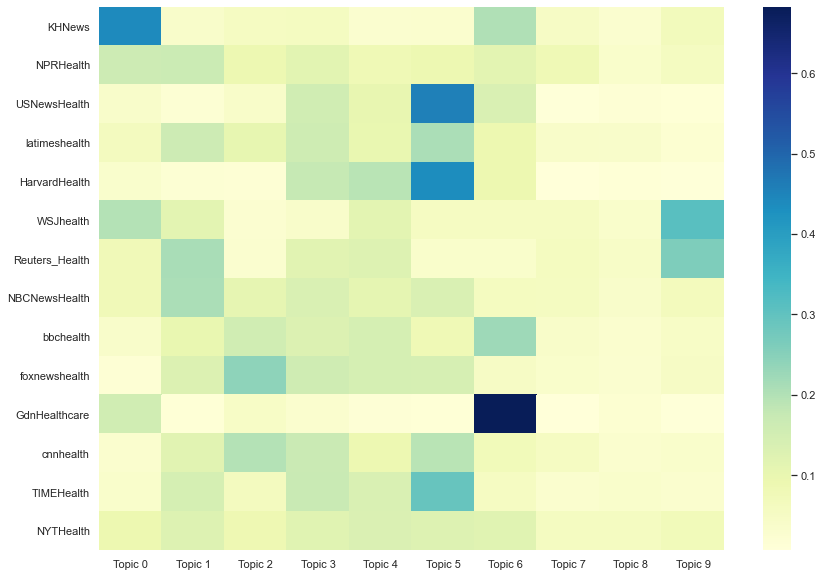

In [125]:
# Display heat map of topics vs news sources
fig, ax = plt.subplots(figsize=(14,10))
sns.set(font_scale=1)
sns.heatmap(user_topic_counts_ratio, cmap="YlGnBu", ax=ax);
plt.show()

In [126]:
# Convert date to datetime
tweets_df['date'] = pd.to_datetime(tweets_df['date'], errors='coerce')

# Add column for year
tweets_df['year'] = tweets_df['date'].dt.year

In [127]:
# Re-index dataframe by year
reindexed_tweets = tweets_df['dominant_topic']
reindexed_tweets.index = tweets_df['year']

In [128]:
# Generate counts of tweets per topic across years
n_topics = mgp.K
years_range = sorted(tweets_df['year'].unique(), reverse=False)

yearly_keys = []
for year in years_range:
    yearly_keys.append(reindexed_tweets[year].values)
    
yearly_counts = []
for keys in yearly_keys:
    categories, counts = keys_to_counts(keys)
    yearly_counts.append(counts)

yearly_topic_counts = pd.DataFrame(np.array(yearly_counts), index=range(2014,2020+1))
yearly_topic_counts.columns = ['Topic {}'.format(i) for i in range(n_topics)]

yearly_topic_counts

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
2014,2223,4857,2547,3267,3031,3367,2355,987,782,1743
2015,2259,2327,2994,3574,3169,5044,5453,1029,777,1260
2016,2438,3686,3954,4267,3453,5264,4889,1245,869,2135
2017,4472,2460,3495,3843,3477,4664,4783,1435,1004,3175
2018,2617,2970,2881,4049,3369,4131,4270,1623,1428,2872
2019,2964,1968,1730,3405,3051,3971,3280,1562,1438,1748
2020,1117,3090,493,642,556,997,1455,403,379,329


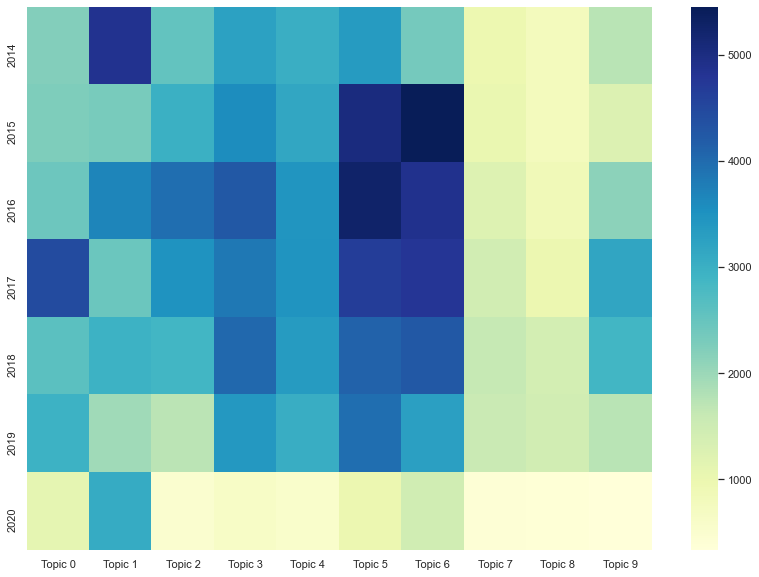

In [129]:
# Display heat map of topics vs years
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(yearly_topic_counts, cmap="YlGnBu", ax=ax);
plt.show()